In [1]:
import vectorbt as vbt
import numpy as np
import pandas as pd

In [2]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 5)

# data

Load OHLC data from cryptocurrency exchange Poloniex

In [3]:
ohlc_df = vbt.data.load_cryptopair('USDT_BTC', vbt.data.ago_dt(days=30), vbt.data.now_dt())
ohlc_df.head()

done. 1.41s


,O,H,L,C,V
date,,,,,
2017-10-24 18:05:00,5699.000000,5700.894682,5699.0,5699.000000,95726.489663
2017-10-24 18:10:00,5700.000000,5708.966042,5700.0,5708.966042,59329.143743
2017-10-24 18:15:00,5708.966042,5710.000000,5700.0,5710.000000,24565.732343
2017-10-24 18:20:00,5710.000000,5711.000000,5701.0,5708.000000,12205.319263
2017-10-24 18:25:00,5707.000000,5711.409710,5700.0,5705.000010,44398.778195


In [4]:
# No future data
rate_sr = ohlc_df.O

    count         mean         std      min         25%     50%     75%  \
O  8640.0  6914.622221  813.173005  5302.64  6177.27049  7055.0  7495.0   

           max  
O  8383.465575  


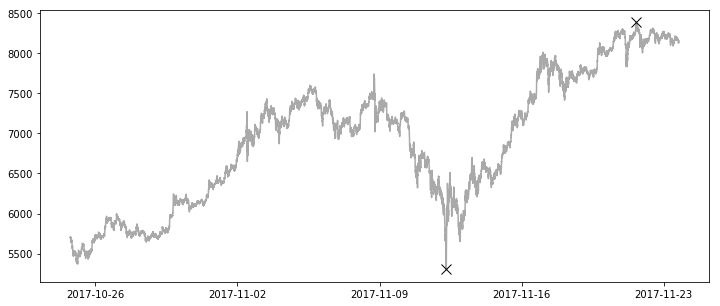

In [5]:
vbt.graphics.plot_line(rate_sr)

# indicators

Calculate EMA indicators

In [6]:
fast_ma_sr = vbt.indicators.EMA(rate_sr, 100)
slow_ma_sr = vbt.indicators.EMA(rate_sr, 300)

# signals

Generate signals based on conditions

    1. Go long whenever fast EMA is over slow EMA, while go short when opposite occurs

In [7]:
ma_evector = vbt.signals.DMAC_evector(fast_ma_sr, slow_ma_sr)
ma_xvector = vbt.signals.DMAC_xvector(fast_ma_sr, slow_ma_sr)

Both, entry and exit vectors, are sequences of 0 and 1 (bit-vectors) to allow fast vector operations.

We reduce both vectors to contain only signals that are first in their sequences, since we are looking for crossover.

In [8]:
ma_evector = vbt.vector.first(ma_evector)
ma_xvector = vbt.vector.first(ma_xvector)

    2. Go short whenever price drops by 10%

In [9]:
trailstop_xvector = vbt.signals.trailstop_xvector(rate_sr, ma_evector, 0.1 * rate_sr)

Combine MA exit strategy with trailing stop and pick every first exit out of sequence.

In [10]:
ma_xvector = vbt.vector.OR(ma_xvector, trailstop_xvector)
ma_xvector = vbt.vector.first(ma_xvector)

To apply an additional filter, generate your own bit-vector and use `vector.AND/OR/XOR` operations

# positions

Generete positions out of both vectors (merge and reduce)

In [11]:
pos_sr = vbt.positions.from_vectors(rate_sr, ma_evector, ma_xvector)
pos_sr.head()

date
2017-10-24 18:10:00    1
2017-10-24 19:00:00   -1
2017-10-25 21:10:00    1
2017-10-27 13:15:00   -1
2017-10-29 07:00:00    1
dtype: int64

Position series has always even number of positions. First position is always long, the last one always short. This kind of fixed structure (`[0::2]` for long, `[1::2]` for short) makes further manipulations, such as calculation of equity, very easy.

Visualize entries and exits

   count        mean         std       min        25%      50%         75%  \
O   24.0  100.743454  440.107048 -957.1754 -48.621902  53.7778  137.713222   

           max  
O  1363.143512  


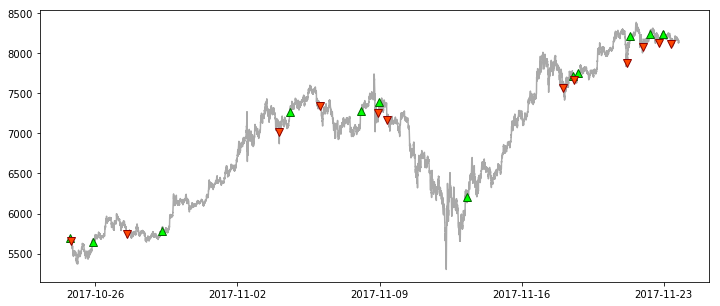

In [12]:
vbt.positions.plot(rate_sr, pos_sr)

# returns

Generate % returns out of positions. Takes into account fees.

In [13]:
posret_sr = vbt.returns.from_positions(rate_sr, pos_sr, 0.0025)
posret_sr.head()

date
2017-10-24 18:10:00   -0.002500
2017-10-24 19:00:00   -0.009437
2017-10-25 21:10:00   -0.002500
2017-10-27 13:15:00    0.015313
2017-10-29 07:00:00   -0.002500
dtype: float64

Position returns series (`posret`) inherits the structure of the position series and make them redundant. Because we apply fees, we get negative returns on long. If fees are zero, returns on long are also zero, but still included in the series. 

Generate hold returns.

In [14]:
vbt.returns.on_hold(rate_sr, 0.0015)

date
2017-10-24 18:05:00   -0.001500
2017-11-23 18:00:00    0.428833
dtype: float64

   count      mean       std       min       25%     50%     75%       max
0   24.0  0.013493  0.062367 -0.032891 -0.006175 -0.0025 -0.0025  0.216712


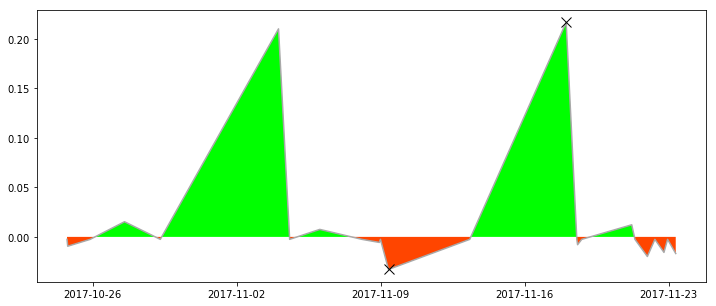

In [15]:
vbt.returns.plot(posret_sr)

# equity

Generate equity in base and quote currency from position returns

In [16]:
equity_df = vbt.equity.from_returns(rate_sr, posret_sr)
equity_df.head()

,base,quote
date,,
2017-10-24 18:05:00,NaN,NaN
2017-10-24 18:10:00,5685.750000,0.9975
2017-10-24 18:15:00,5694.693626,0.9975
2017-10-24 18:20:00,5695.725000,0.9975
2017-10-24 18:25:00,5692.732500,0.9975


Base and quote are NaN before the first entry or if no positions were taken

Visualize both equities

base
    count      mean         std         min         25%       50%         75%  \
0  8639.0 -4.658421  327.068488 -653.568717 -207.854772 -81.25914  187.052949   

           max  
0  1319.320423  


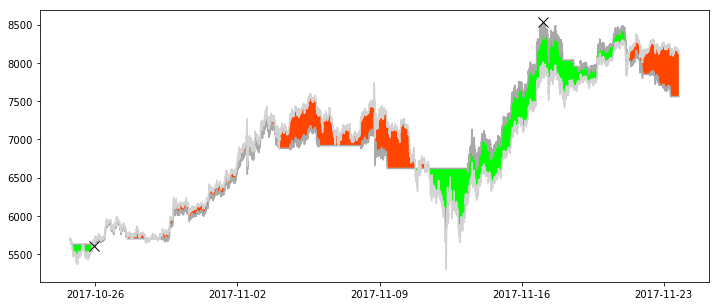

quote
    count      mean       std       min       25%       50%       75%  \
0  8639.0  0.000485  0.046525 -0.089831 -0.025306 -0.012374  0.026975   

        max  
0  0.248804  


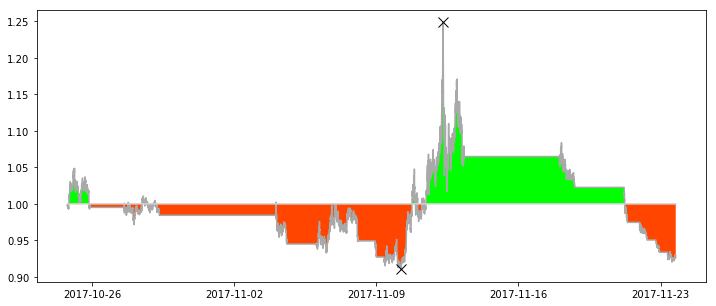

In [17]:
vbt.equity.plot(rate_sr, equity_df)

Equity diffs (`eqd`) are absolute returns if initial investment was 1. They are used in calculation of performance and risk/profit indicators such as sharpe ratio.

In [18]:
eqd_sr = vbt.equity.diffs(posret_sr)
eqd_sr.head()

date
2017-10-24 19:00:00   -0.009413
2017-10-27 13:15:00    0.015092
2017-11-04 00:55:00    0.209780
2017-11-06 01:05:00    0.009119
2017-11-08 22:30:00   -0.006783
dtype: float64

# performance

Print summary of multiple KPIs applied on equity diffs

In [19]:
vbt.performance.print_summary(eqd_sr)

{
  "performance": {
    "profit": 0.36324262229875326,
    "averages": {
      "trade": 0.030270218524896104,
      "gain": 0.10042800482116317,
      "loss": 0.01984248597243751
    },
    "winrate": 0.4166666666666667,
    "payoff": 5.061261223047563,
    "PF": 3.615186587891116,
    "RF": 5.039096170014084
  },
  "risk/return profile": {
    "sharpe": 0.31707151669598166,
    "sortino": 2.59266685369045,
    "maxdd": 0.07208487594665969
  }
}


# optimizer.gridsearch

The classic optimization method is grid search (or exhaustive search). It exhaustively generates candidates from a grid of parameter values and applies them on the series. 

This method brings some advantages:
- its simple to implement
- 2d-combinations can be visualized using heatmaps
- can be used to discover hidden patterns in combinations
- highly parallelizable

But also drawbacks are possible:
- not flexible enough to fit changing financial markets
- prone to overfitting
- no intermediate feedback

**Grid search consists of 4 levels:**

| Level | Motivation | Module | Map structure |
|-|-|-|-|
| 1 | Calculate equity diffs | `seriesmap` | `[(,)]` |
| 2 | Calculate KPIs on equity diffs and compare | `nummap` | `pd.Series` |
| 3 | Combine multiple KPIs into a single score and compare | `scoremap` | `pd.Series` |
| 4 | Find patterns by building a heatmap | `matrix` | `pd.DataFrame` |

At the end we will be able to compare performance of different trading strategies

## L1
## seriesmap

In [20]:
import vectorbt.optimizer.gridsearch as grids

Calculate equity diffs for a range of EMA combinations

    1. Precalculate all EMAs

In [21]:
# Init
ma_func = lambda window: vbt.indicators.EMA(rate_sr, window)
min_ma, max_ma, step = 1, 1000, 10
fees = 0.0025

# Cache moving averages
param_range = grids.params.range_params(min_ma, max_ma, step)
mamap = dict(grids.seriesmap.from_func(ma_func, param_range))

cores: 4
processes: 3
starmap: False
calcs: 101 (~0.05s) ..
done. 0.27s


    2. For each EMA combination, generate respective equity diffs

In [22]:
# Func
def ma_eqdfunc(fast_ma, slow_ma):
    # Requires multiple layers of calculations
    fast_ma_sr = mamap[fast_ma]
    slow_ma_sr = mamap[slow_ma]
    entries = vbt.vector.first(vbt.signals.DMAC_evector(fast_ma_sr, slow_ma_sr))
    exits = vbt.vector.first(vbt.signals.DMAC_xvector(fast_ma_sr, slow_ma_sr))
    pos_sr = vbt.positions.from_vectors(rate_sr, entries, exits)
    posret_sr = vbt.returns.from_positions(rate_sr, pos_sr, fees)
    eqd_sr = vbt.equity.diffs(posret_sr)
    return eqd_sr

# Params
param_space = grids.params.combine_rep_params(min_ma, max_ma, step, 2)

In [23]:
ma_eqdmap = grids.seriesmap.from_func(ma_eqdfunc, param_space)

cores: 4
processes: 3
starmap: True
calcs: 5151 (~16.91s) ..
done. 13.89s


Generate equity diffs for random positions. Number of positions is the same as for EMA, to be comparable.

In [24]:
# Func
def random_eqdfunc(n):
    entries = vbt.signals.random_vector(rate_sr, n)
    exits = vbt.signals.random_vector(rate_sr, n, excl_vector=entries)
    pos_sr = vbt.positions.from_vectors(rate_sr, entries, exits)
    posret_sr = vbt.returns.from_positions(rate_sr, pos_sr, fees)
    eqd_sr = vbt.equity.diffs(posret_sr)
    return eqd_sr

# Params
param_range = np.array(grids.mapper.map(lambda sr: len(sr.index), list(zip(*ma_eqdmap))[1]))+1

cores: 4
processes: 3
starmap: False
calcs: 5151 (~0.02s) ..
done. 4.09s


In [25]:
random_eqdmap = grids.seriesmap.from_func(random_eqdfunc, param_range)

cores: 4
processes: 3
starmap: False
calcs: 5151 (~26.50s) ..
done. 16.10s


## L2
## nummap

Apply KPI on each equity diffs series

In [26]:
ma_exp_sr = grids.nummap.from_seriesmap(ma_eqdmap, vbt.performance.expectancy)

cores: 4
processes: 3
starmap: False
calcs: 5151 (~0.22s) ..
done. 2.88s
min (11, 141): -0.00215651240915
max (721, 1001): 0.146631509063


In [27]:
ma_sharpe_sr = grids.nummap.from_seriesmap(ma_eqdmap, vbt.performance.sharpe)

cores: 4
processes: 3
starmap: False
calcs: 5151 (~0.61s) ..
done. 3.01s
min (1, 11): -0.327563064748
max (761, 961): 1.07994344653


In [28]:
random_exp_sr = grids.nummap.from_seriesmap(random_eqdmap, vbt.performance.expectancy)

cores: 4
processes: 3
starmap: False
calcs: 5151 (~0.41s) ..
done. 2.86s
min 1: -0.142142877063
max 1: 0.469321649749


Compare quantile distributions of EMA and random strategy KPIs

            count      mean       std       min       25%       50%       75%  \
nummap     5050.0  0.071204  0.030704 -0.002157  0.058243  0.081518  0.088412   
benchmark  5151.0  0.045938  0.054416 -0.142143  0.009018  0.034270  0.071560   

                max  
nummap     0.146632  
benchmark  0.469322  


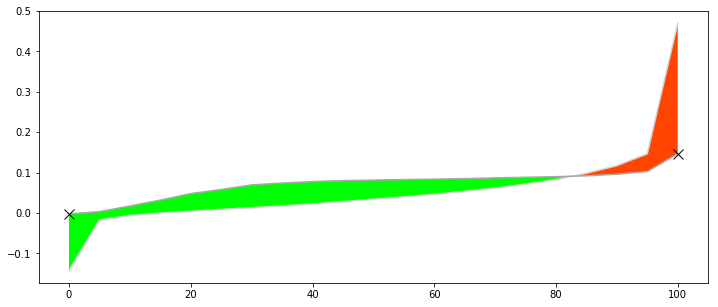

In [29]:
grids.nummap.compare_quantiles(ma_exp_sr, random_exp_sr)

Compare KPI distribution to that of random map

            count      mean       std       min       25%       50%       75%  \
nummap     5050.0  0.071204  0.030704 -0.002157  0.058243  0.081518  0.088412   
benchmark  5151.0  0.045938  0.054416 -0.142143  0.009018  0.034270  0.071560   

                max  
nummap     0.146632  
benchmark  0.469322  


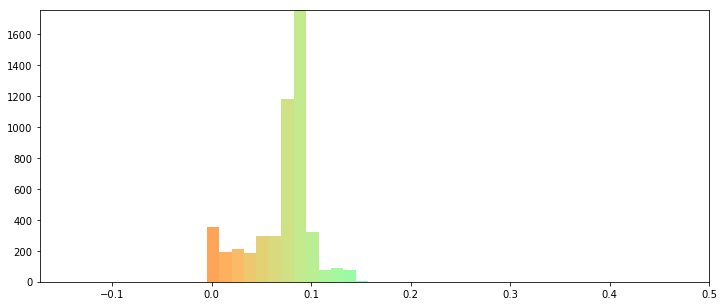

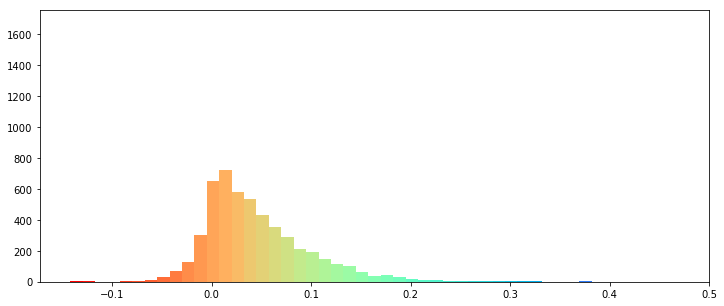

In [30]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
grids.nummap.compare_hists(ma_exp_sr, random_exp_sr, 50, cmap, norm)

## L3
## scoremap

Take into account multiple weighted KPIs and generate a score from 1 to 100

In [31]:
ma_scoremap_sr = grids.scoremap.from_nummaps([ma_exp_sr, ma_sharpe_sr], [2/3, 1/3], [False, False])

done. 0.01s
min (1, 1): 1.0
max (721, 1001): 99.9521794316


## L4
## matrix

Reshape 2d-parameter grid into a matrix and display as a heatmap

In [32]:
ma_matrix_df = grids.matrix.from_nummap(ma_exp_sr, symmetric=True).fillna(0)

done. 1.51s


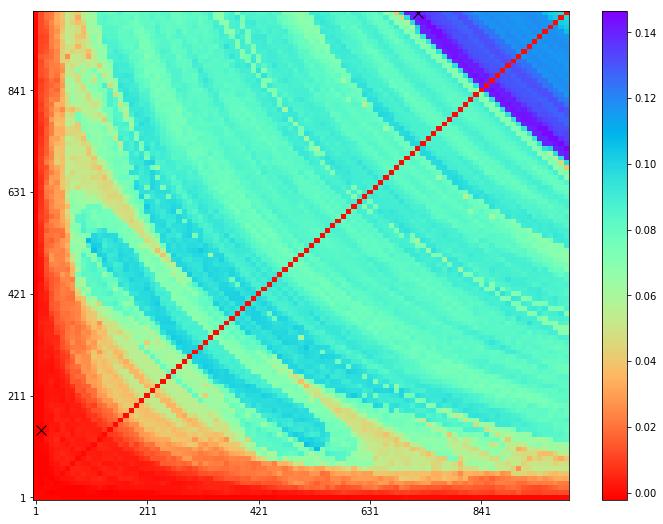

In [33]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
grids.matrix.plot(ma_matrix_df, cmap, norm)
matplotlib.rcParams['figure.figsize'] = (12, 5)